### Problem

#### MLPs dont take into account the spatial information. 

### Convolutional neural networks to the rescue!

![title](img/cnn.png)


##### Some important things to know:
1. Look at patches of the image. Analyze each patch individually via kernels.
2. Each kernel identifies some "concept". (or so they say https://arxiv.org/pdf/1311.2901.pdf )
3. The "deeper" the layer , the mode "abstract" detected concepts: e.g. lines -> shapes -> cat ears -> cat
4. Get translational invariance via max pooling.
![title](img/convolution.png)


##### The convolution has 3 important paramaters:
    1. Filter size (how large are the patches)
    2. Stride (how many 
    3. Padding


#### Steps
    1. Replace the dense layers (the tf.matmul thing) with convolutional layers
    2. Add pooling
    3. Add dense layers at the end.
   
#### Training stays the same!


In [1]:
#The usual imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

### Prepare data

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


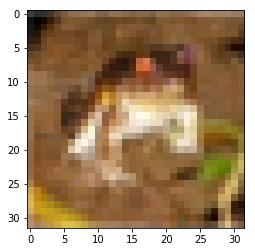

In [2]:
def transform_labels(numerical_labels):
    #use one hot encoding of labels instead of numeric
    #e.g. 2 will become [0,0,1,0,0,0,...]
    categorical = np.zeros((len(numerical_labels),10))
    for idx,label in enumerate(numerical_labels):
        categorical[idx][label] = 1
    return categorical


#Load mnist (the "hello world" of machine learning)
(train_img,train_label),(test_img,test_label) = tf.keras.datasets.cifar10.load_data()
plt.imshow(train_img[0],cmap='gray')

train_label = transform_labels(train_label)
test_label  = transform_labels(test_label)
print (train_img.shape,train_label.shape,test_img.shape,test_label.shape)

### Define the dataflow 

In [8]:
#Inputs in the dataflow graph
image_input = tf.placeholder(tf.float32,shape=(None,train_img.shape[0],train_img.shape[1],train_img.shape[2]))
label_input = tf.placeholder(tf.int16,shape=(None,10))

#The flow is just a series of convolution and pooling operations
conv1 = tf.layers.conv2d(image_input, filters=16,kernel_size=5, activation=tf.nn.relu)
conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

conv2 = tf.layers.conv2d(conv1, filters = 32, kernel_size=3, activation=tf.nn.relu)
conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

conv3 = tf.layers.conv2d(conv2, filters = 64, kernel_size = 3, activation=tf.nn.relu)
conv3 = tf.layers.max_pooling2d(conv3, 2, 2)

flat = tf.layers.flatten(conv3)
predicted_logits = tf.layers.dense(flat,10)

error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_logits,labels=label_input))

#Define the optimizer; this is the thing that actually minimizez the error;
#It looks at all the variables that contribute to the error and adjusts them 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(error)

#Record the error for tensorboard
#During training we run "tensorboard --logdir=/path/to/logs""

error_summary = tf.summary.scalar('average_error', error) 
#We need to ru this in order to initialize the variables
init = tf.global_variables_initializer()

#At this point the blueprint is created. 

### Perform the training

In [9]:
#How many passes through the data should we do
num_epochs = 10
#How many images at once
batch_size  = 32

with tf.Session() as sess:
    #Initialize the weights and bias
    sess.run(init)
    #Define the model saver. We will subsequently load the model in order to use it.
    saver = tf.train.Saver()
    
    #Define the actual tensorboard logger
    summary_writter = tf.summary.FileWriter('./mnist_training_summary',sess.graph)

    #At each passing you want to feed the data in a different order
    read_order = np.arange(len(train_img))
    batch_idx = 0
    
    #Let's see what we get when we just use the random weights
    logits,test_loss = sess.run([predicted_logits,error],feed_dict={
                image_input:test_img,
                label_input:test_label
            })
    print("Initial number of errors: {}".format(np.count_nonzero(np.argmax(logits,axis=1)-np.argmax(test_label,axis=1))))
    
    for epoch in range(num_epochs):
        
        #Feed images, get predictions, apply gradients - all just by running "optimizer" operation
        while batch_idx+batch_size<len(train_img): 
            _,summary = sess.run([optimizer,error_summary],feed_dict={
                image_input:train_img[read_order[batch_idx:batch_idx+batch_size]],
                label_input:train_label[read_order[batch_idx:batch_idx+batch_size]]
            })
            batch_idx+=batch_size
            
            #Log the error at the current training step in order to be visualised in tensorboard
            training_step = len(train_img)/batch_size*epoch+batch_idx/batch_size
            summary_writter.add_summary(summary,training_step) 
        
        #Test the model after each epoch
        logits,test_loss = sess.run([predicted_logits,error],feed_dict={
                image_input:test_img,
                label_input:test_label
            })
        
        print("Number  of errors after epoch {} is: {}".format(epoch,np.count_nonzero(np.argmax(logits,axis=1)-np.argmax(test_label,axis=1))))
        
        #Save the model after each epoch
        saver.save(sess, './mnist_model',global_step=epoch)
        
        #Prepare for the next epoch; need to shuffle the data and reset the index
        np.random.shuffle(read_order)
        batch_idx=0
        #For cooler ways to handle the data google "tf.data" 

Initial number of errors: 8997
Number  of errors after epoch 0 is: 8935
Number  of errors after epoch 1 is: 8114
Number  of errors after epoch 2 is: 7596
Number  of errors after epoch 3 is: 7084
Number  of errors after epoch 4 is: 6817
Number  of errors after epoch 5 is: 6488
Number  of errors after epoch 6 is: 6395
Number  of errors after epoch 7 is: 5965
Number  of errors after epoch 8 is: 5984
Number  of errors after epoch 9 is: 5899


### Restore the saved model

In [6]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("./mnist_model-9.meta")
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    logits,test_loss = sess.run([predicted_logits,error],feed_dict={
                image_input:test_img,
                label_input:test_label
            })
        
    print("Final number of errors is: {}".format(np.count_nonzero(np.argmax(logits,axis=1)-np.argmax(test_label,axis=1))))
        

INFO:tensorflow:Restoring parameters from ./mnist_model-9
Final number of errors is: 1147


# Exercises

##### Modify the above code to:
1. Add one more dense layer at the end.
2. Use more kernels.
3. Replace maxpooling with better striding
4. Add dropout
5. Use batch normalization